# Builder Locations

Generate a map of the united states using only census data, then overlay all zip codes where one or more specified builders are located.

Also make sure to look at the related notebooks named `home_prices.ipynb` and `housing_growth.ipynb`

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
# Get all locations in the United States
zip_df = pd.read_csv('../inputs/zip_codes.csv', dtype={'Zip Code': str}) # State (abbreviated and full), City, Zip Code, Lat, Long
zip_df.head()

,State,State Abbreviated,City,Zip Code,Latitude,Longitude
0,Alabama,AL,Abbeville,36310,31.5755,-85.2790
1,Alabama,AL,Abernant,35440,33.3110,-87.1898
2,Alabama,AL,Adamsville,35005,33.5884,-86.9597
3,Alabama,AL,Addison,35540,34.2056,-87.1948
4,Alabama,AL,Adger,35006,33.4343,-87.1675


In [31]:
# Get home builder locations in the United States
home_sales_df = pd.read_csv('../inputs/home_sales_bhi.csv')
home_sales_df['Zip Code'] = home_sales_df['BHIZip'].astype('str').str.rstrip('.0')
home_sales_df = home_sales_df.drop(['BHIZip'], axis=1)
home_sales_df.head()

,IndustryPlanID,BHIBrandName,BHISubDivisionName,BHIState,BHICity,CalculatedLatitude,CalculatedLongitude,PlanName,Bedrooms,Baths,BaseSqFt,Garage,Stories,BasePrice,ZondaProjectID,Zip Code
0,53,Saddlehorn,Saddlehorn,SC,Pelzer,34.66246,-82.35823,Williamsburg A,4,3,2915,2,2,524990,30804,29669
1,64,Saddlehorn,Saddlehorn,SC,Pelzer,34.66246,-82.35823,Tryon A,5,3,3584,2,2,589990,30804,29669
2,67,Saddlehorn,Saddlehorn,SC,Pelzer,34.66246,-82.35823,Georgetown A,2,2,1879,2,1,439990,30804,29669
3,85,Perry Homes,The Village of Mill Creek 60',TX,Seguin,29.61367,-98.01453,3395W,4,3,3395,3,2,571900,14584,78155
4,109,Classic Homes,Wolf Ranch,CO,Colorado Springs,38.97539,-104.71900,Hillspire,5,3,3272,3,1,626000,287216,80924


In [32]:
# Separate builder locations from remaining locations
df = pd.merge(zip_df, home_sales_df, on='Zip Code', how='outer')
del zip_df # Free memory
del home_sales_df # Free memory
df = df.drop(['BasePrice', 'BaseSqFt', 'Baths', 'Bedrooms', 'BHICity', 'BHIState', 'BHISubDivisionName', 'CalculatedLatitude', 'CalculatedLongitude', 'City', 'Garage', 'IndustryPlanID', 'PlanName', 'State', 'State Abbreviated', 'Stories', 'ZondaProjectID'], axis=1)
df = df.rename(columns={'BHIBrandName': 'Brand'})
# Define the boundaries of the continental United States
us_bounds = { 'lat_min': 24.5, 'lat_max': 49.5, 'lon_min': -124.75, 'lon_max': -66.95 }
# Remove Hawaii and Alaska
us_df = df[(df['Latitude'] >= us_bounds['lat_min']) &
           (df['Latitude'] <= us_bounds['lat_max']) &
           (df['Longitude'] >= us_bounds['lon_min']) &
           (df['Longitude'] <= us_bounds['lon_max'])]
centex_df = df[(df['Brand'] == 'Centex Homes')]
delwebb_df = df[(df['Brand'] == 'Del Webb')]
pulte_df = df[(df['Brand'] == 'Pulte Homes')]
# Filter the dataFrame to exclude rows with zip codes in the builder DataFrames
us_df = us_df[~us_df['Zip Code'].isin(centex_df['Zip Code'])]
us_df = us_df[~us_df['Zip Code'].isin(delwebb_df['Zip Code'])]
us_df = us_df[~us_df['Zip Code'].isin(pulte_df['Zip Code'])]
del df # Free memory
pulte_df.head()

,Zip Code,Latitude,Longitude,Brand
1189,85326,33.3703,-112.5838,Pulte Homes
1190,85326,33.3703,-112.5838,Pulte Homes
1191,85326,33.3703,-112.5838,Pulte Homes
1192,85326,33.3703,-112.5838,Pulte Homes
1497,85132,32.9969,-111.3612,Pulte Homes


In [33]:
# Get locations where we should be building
recommended_locations_df = pd.read_csv('../outputs/housing_growth.csv')
# Only recommend the top 10 locations (requires high population, and predicted continued growth)
min_population = 10000
max_recomendations = 10
recommended_locations_df = recommended_locations_df[(recommended_locations_df['Total Population'] >= min_population) & (recommended_locations_df['% Difference'] > 0)]
recommended_locations_df = recommended_locations_df.sort_values(['% Difference', 'Predicted Occupied Housing Units'], ascending=False).reset_index(drop=True)
# Define the boundaries of the continental United States
us_bounds = { 'lat_min': 24.5, 'lat_max': 49.5, 'lon_min': -124.75, 'lon_max': -66.95 }
# Remove Hawaii and Alaska
recommended_locations_df = recommended_locations_df[(recommended_locations_df['Latitude'] >= us_bounds['lat_min']) &
           (recommended_locations_df['Latitude'] <= us_bounds['lat_max']) &
           (recommended_locations_df['Longitude'] >= us_bounds['lon_min']) &
           (recommended_locations_df['Longitude'] <= us_bounds['lon_max'])]
recommended_locations_df = recommended_locations_df.head(max_recomendations)
recommended_locations_df = recommended_locations_df[['State', 'City', 'Latitude', 'Longitude']]
recommended_locations_df.head(max_recomendations)

,State,City,Latitude,Longitude
0,California,Santa Cruz,36.9959,-122.0578
1,California,Soledad,36.4196,-121.3243
2,Ohio,Dayton,39.7238,-84.1854
3,New Hampshire,Durham,43.1174,-70.9197
4,Maryland,Ocean City,38.3365,-75.0849
5,Massachusetts,Nantucket,41.2725,-70.0932
6,California,Oxnard,34.1685,-119.1717
7,Pennsylvania,Villanova,40.0399,-75.3459
8,California,Santa Ana,33.7489,-117.9072
9,Colorado,Breckenridge,39.4753,-106.0225


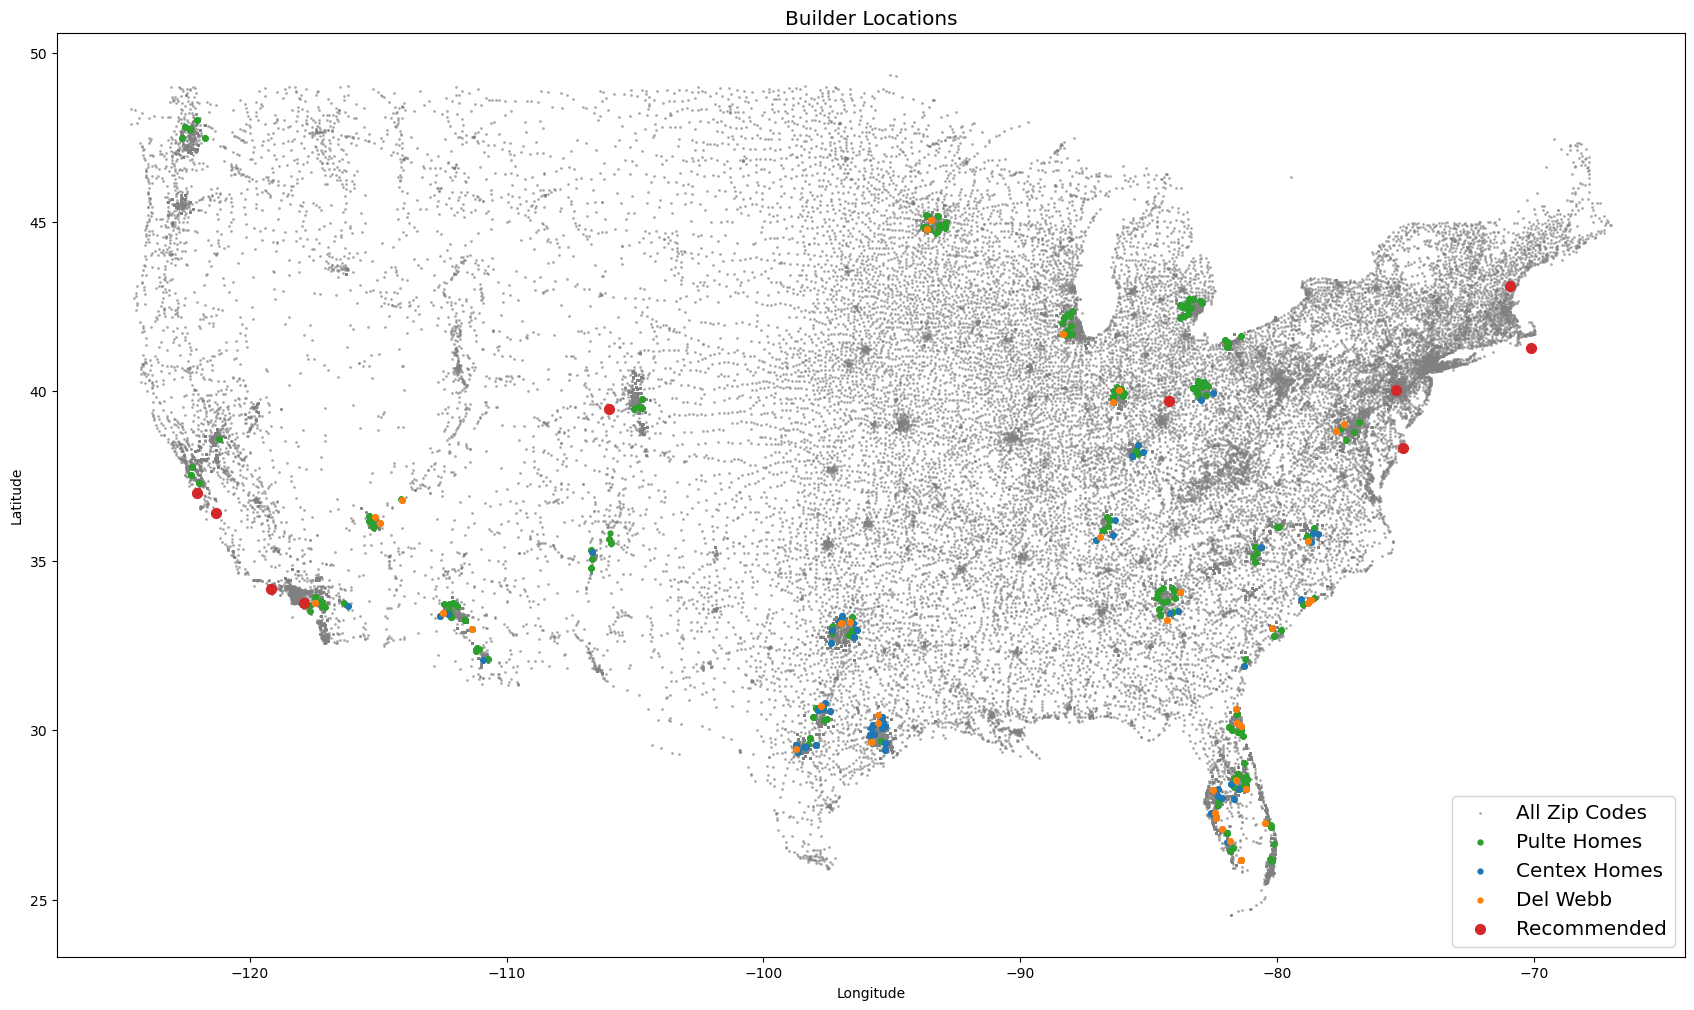

In [34]:
builder_dot_size = 50

plt.figure(figsize=(21,12))
plt.scatter(us_df['Longitude'],us_df['Latitude'], c='grey', marker='.', s=(builder_dot_size/10), alpha=0.5, label='All Zip Codes')
plt.scatter(pulte_df['Longitude'],pulte_df['Latitude'], c='C2', marker='.', s=builder_dot_size, label='Pulte Homes')
plt.scatter(centex_df['Longitude'],centex_df['Latitude'], c='C0', marker='.', s=builder_dot_size, label='Centex Homes')
plt.scatter(delwebb_df['Longitude'],delwebb_df['Latitude'], c='C1', marker='.', s=builder_dot_size, label='Del Webb')
plt.scatter(recommended_locations_df['Longitude'],recommended_locations_df['Latitude'], c='C3', marker='.', s=builder_dot_size*4, label='Recommended')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("Builder Locations", fontsize='x-large')
plt.show()